Run 1 meta data generation

# Load Libraries

In [6]:
suppressPackageStartupMessages({
    library(MASS)
    library(gdata)
    library(singlecellmethods)
    library(matrixStats)
    library(data.table)
    library(viridis)
    #library(seaborn)
    library(RColorBrewer)
    library(pheatmap)
    library(Matrix)
    library(harmony)
    library(uwot)
    library(irlba)
    library(Seurat)
    library(factoextra)
    library(presto) 
    source("utils.R")
    source("misc_funcs.R")
    library(tidyverse)
    library(Biostrings)
    library(ggpubr)
    library(ggridges)
    library(ggrepel)
})


# Import

In [117]:
#exprs <- readMM("filt_exprs_rna.mtx")
#colnames(exprs) <- read.csv("filt_colnames_exprs_rna.csv")[,2]
#rownames(exprs) <- read.csv("rownames_exprs_rna.csv")[,2]

filt_exprs <- readMM("filt_exprs.mtx")
colnames(filt_exprs) <- read.csv("filt_colnames_exprs_rna.csv")[,2]
rownames(filt_exprs) <- read.csv("filt_rownames_exprs_rna.csv")[,2]

counts_adt <- readMM("exprs_adt.mtx")
colnames(counts_adt) <- read.csv("colnames_exprs_adt.csv")[,2]
rownames(counts_adt) <- read.csv("rownames_exprs_adt.csv")[,2]

counts_adt_filt <- readMM("filt_exprs_adt.mtx")
colnames(counts_adt_filt) <- read.csv("filt_colnames_exprs_adt.csv")[,2]
rownames(counts_adt_filt) <- read.csv("filt_rownames_exprs_adt.csv")[,2]

meta <- read.csv("meta_rna.csv", row.names = 1)
filt_meta <- read.csv("filt_meta_rna.csv", row.names = 1)

meta_adt <- read.csv("meta_adt.csv", row.names = 1)
filt_meta_adt <- read.csv("filt_meta_adt.csv", row.names = 1)

In [71]:
FlowMatrix <- read_csv("FlowMatrixFinal.csv")

Rows: 5760 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): RPL8_Control, IL2RA_Control, CTLA4_Control, Polarization_Index, cell
dbl (11): SPARKUV_CD45, BV421_CD45, BV605_CD45, BV750_CD45, SSC, FSC, FITC_C...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
alleles_DNA <- read_csv("alleles_DNA-Reseq.csv")

Rows: 11709 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (13): DNA_Barcode, Well_ID, Aligned_Sequence, PlateLabel, Condition, RNA...
dbl  (5): n_deleted, n_inserted, n_mutated, #Reads, %Reads

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [28]:
plateMeta0 <- read_csv("RPL8_IL2RA_CTLA4Meta.csv")

Rows: 18 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): PlateLabel, Condition, RNA_Barcode, DNA_Barcode, ADT_Barcode, sgRNA...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [32]:
plateMeta <- read_csv("RPL8_IL2RA_CTLA4Meta-Reseq.csv")

Rows: 18 Columns: 9
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (9): PlateLabel, Condition, RNA_Barcode, DNA_Barcode, ADT_Barcode, sgRNA...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# IL2RA DNA Analysis

In [22]:
DNAfiles = "Alleles_Trim/"

In [9]:
#Alleles Function for Import -top 10 per cell. 
AllelesFunction <- 
function (filepath, number_of_alleles = 10, folder_name="Alleles") #Filepath is the folder with all the allele tables. 
{
    files <- list.files(path = filepath, pattern = ".txt$", full.names = T, 
        recursive = T) 
    
    matrix <- suppressMessages({
        suppressWarnings({
            lapply(files, read_tsv, n_max = number_of_alleles, col_select = c(1, 
                5, 6, 7, 8, 9))
        })
    })
    names(matrix) <- lapply(files, FUN = 
      function(x) { 
          paste0(substr(x, str_locate(x, paste0(folder_name, "/"))[2]+1, str_locate(x, "/CRISPRessoBatch_on_batch")[1]-1), #modified for Full
                            "_", 
                             substr(x, str_locate(x, "CRISPResso_on_([A-Z])(\\d)")[2]-1, str_locate(x, "/Alleles_frequency_table.txt")[1]-1))})
    
    matrix <- bind_rows(matrix, .id = "Plate_Well")
    return(matrix)
}

In [23]:
#Upload all Alleles
alleles_DNA <- AllelesFunction(DNAfiles, folder_name="Alleles_Trim/")

In [25]:
alleles_DNA %>% write_csv("alleles_DNA_Trim_updated.csv")

In [299]:
alleles_DNA <- read_csv("alleles_DNA_Trim_updated.csv")

Rows: 18432 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Plate_Well, Aligned_Sequence
dbl (5): n_deleted, n_inserted, n_mutated, #Reads, %Reads

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [300]:
alleles_DNA<- alleles_DNA %>% separate(Plate_Well, into = c("Barcode_DNA","Well_ID")) 

In [301]:
alleles_DNA_IL2RA <- alleles_DNA %>% inner_join(dplyr::rename(plateMeta0, Barcode_DNA = DNA_Barcode)) %>% filter(Condition == "IL2RA")

Joining with `by = join_by(Barcode_DNA)`


In [302]:
source("../DNA_filtering_Functions.R")

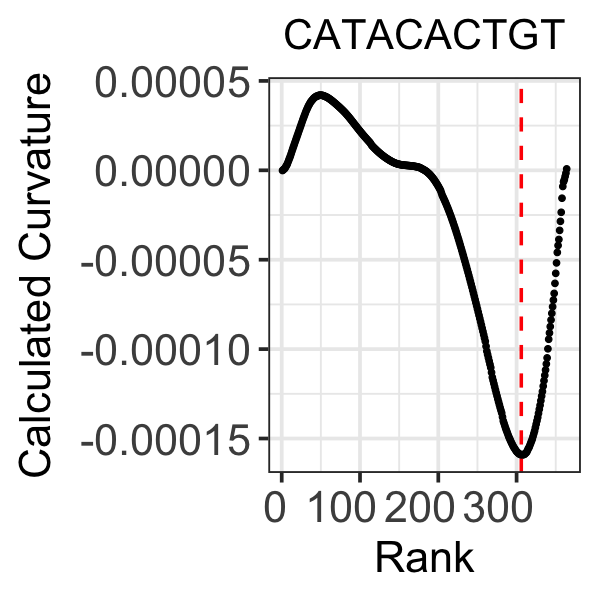

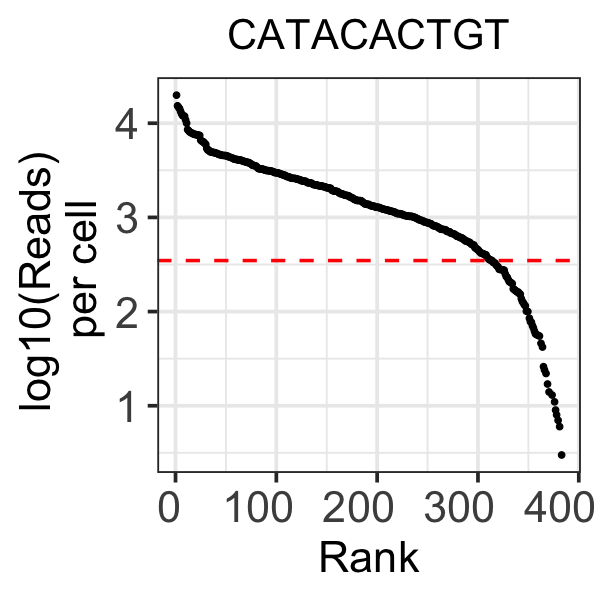

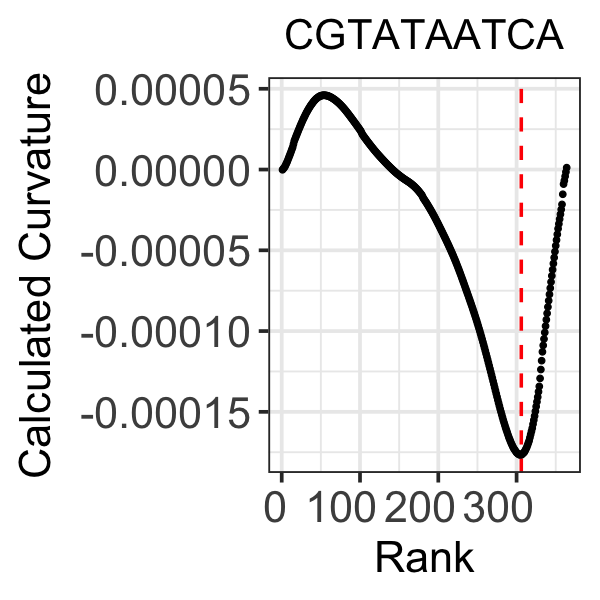

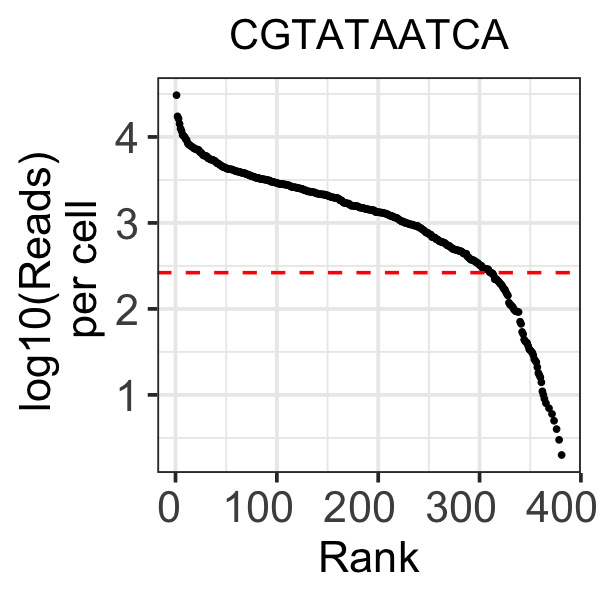

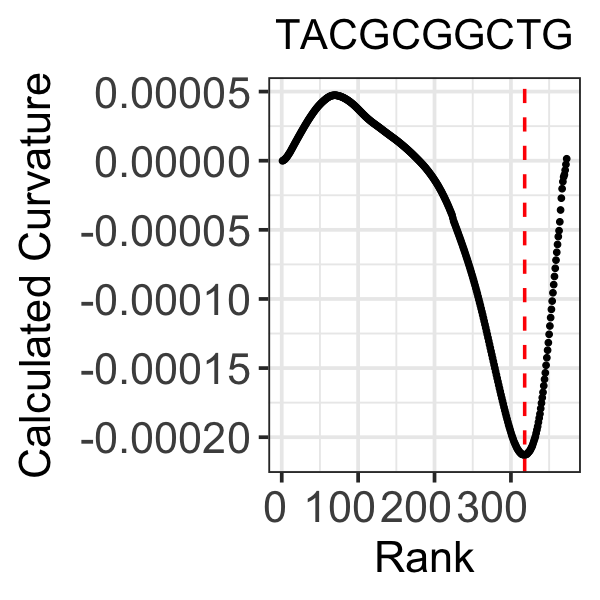

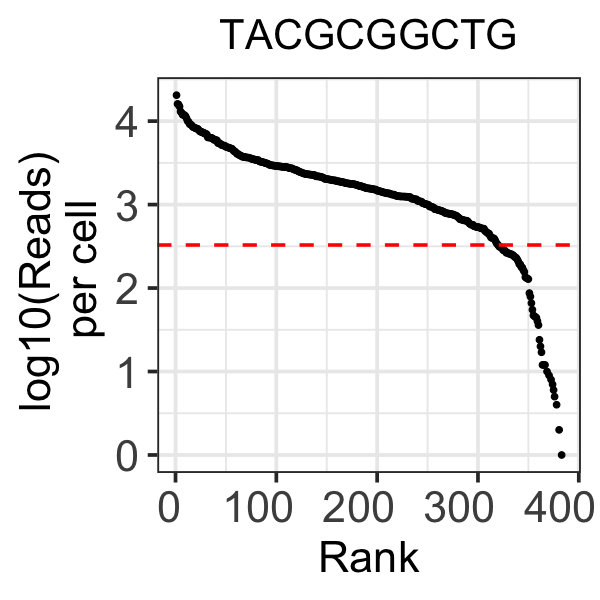

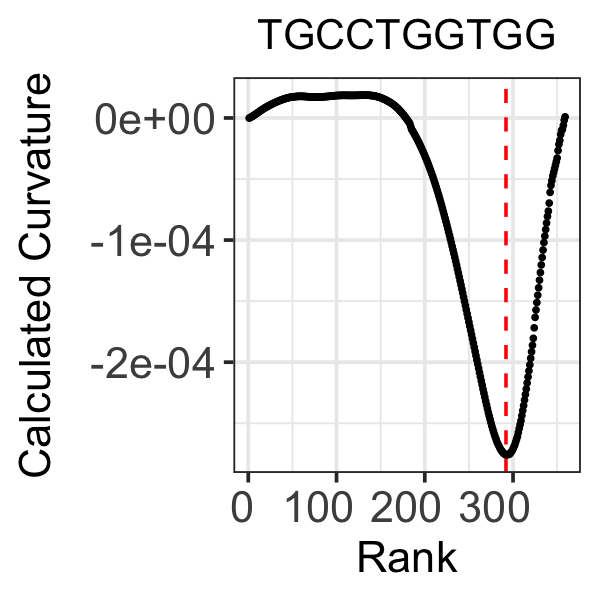

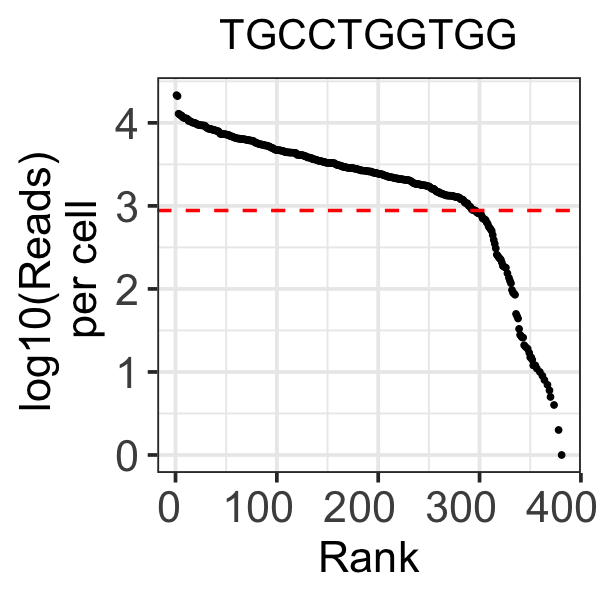

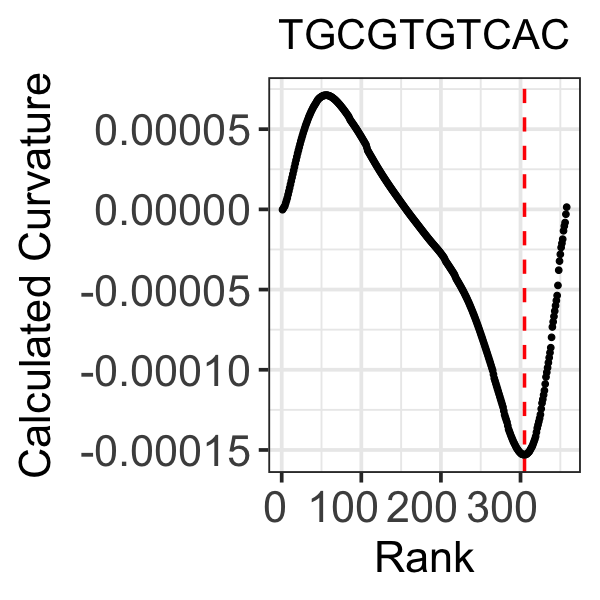

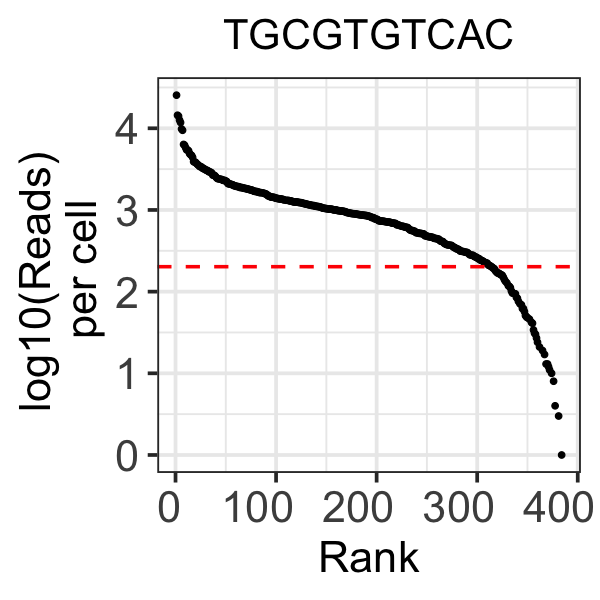

In [321]:
fig.size(5,5)
alleles_DNA_IL2RA_filt <- alleles_DNA_IL2RA %>% Filtering_Cells_Read

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


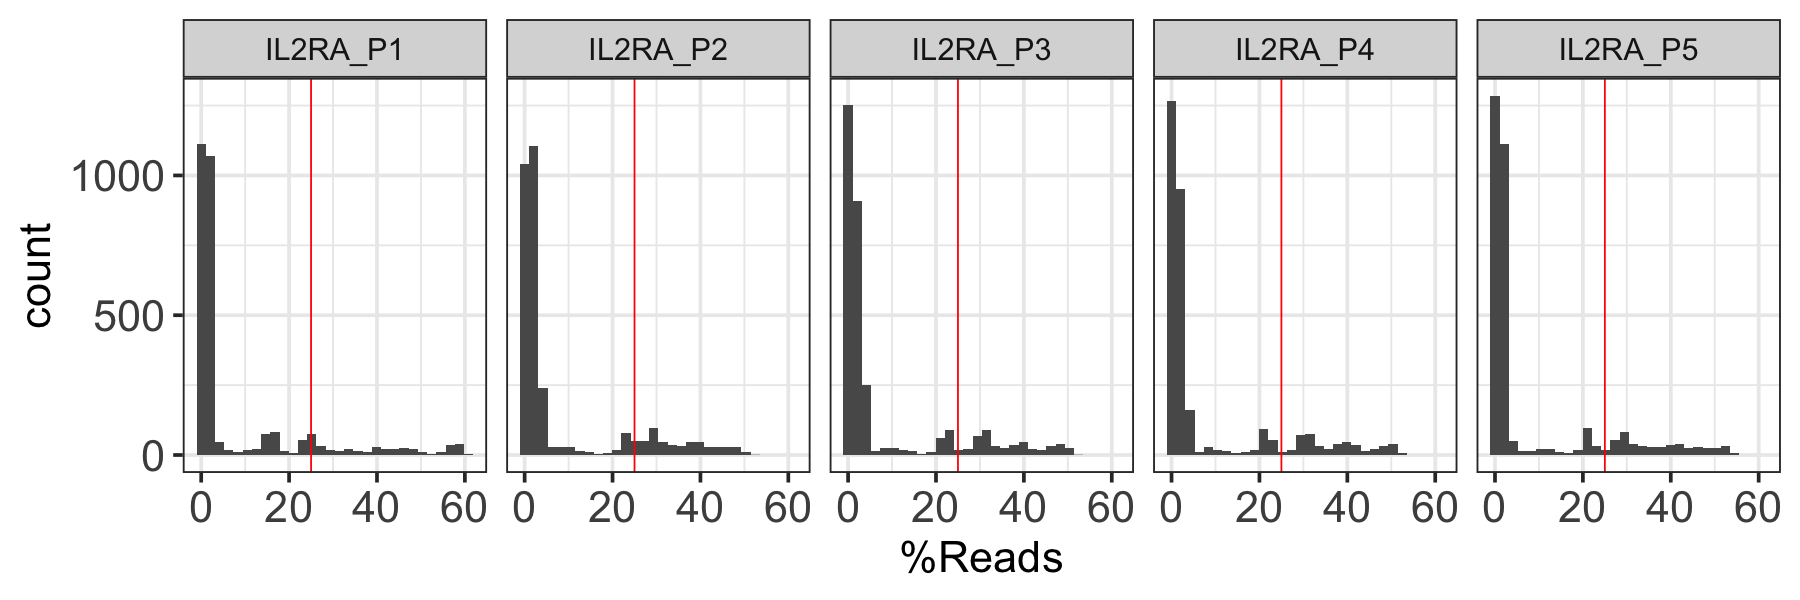

In [322]:
fig.size(5,15)
#Define a cutoff
alleles_DNA_IL2RA_filt%>% 
    ggplot(aes(`%Reads`)) + geom_histogram() + 
    theme_gy() + geom_vline(xintercept = 25, color = "red") + facet_grid(~PlateLabel)

In [323]:
alleles_DNA_IL2RA_filt <- Filtering_Alleles(alleles_DNA_IL2RA_filt, cutoff = 25)

In [324]:
alleles_DNA_IL2RA_filt

Barcode_DNA,Well_ID,Aligned_Sequence,n_deleted,n_inserted,n_mutated,#Reads,%Reads,PlateLabel,Condition,RNA_Barcode,ADT_Barcode,sgRNA_Sequence,Reference,ExpectedChange,Read,plate_well,TotalReads
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
CATACACTGT,A1,CACCCACTCTTTTCTGTTTGGGACCAAAATAGATACCTCCTTCAGAAGCCGCTGCTTTCTGTACTCTCAGCAATAAAAAAACAAAGGCTAGGATAGGTGTGTGCT,0,0,0,1233,47.06107,IL2RA_P3,IL2RA,ACAATAGAGT,CGGTTATTAG,TATCTATTTTGGTCCCAAAC,CTGAGAGTACAGAAAGCAGCGGCTTCTGAAGGAGGTATCTATTTTGGTCCCAAACAGAAAAGAGTGGGTGATTCTGTGGGCAGAGGTGGCAATTCCTGAATGTGGTATGGTGACTCACGC,C_T,R2,CATACACTGTA1,2620
CATACACTGT,A10,CACCCACTCTTTTCTGTTTGGGACCAAAATAAATACCTCCTTCAGAAGCCGCTGCTTTCTGTACTCTCAGCAATAAAAAAACAAAGGCTAGGATAGGTGTGTGCT,0,0,1,1250,39.63221,IL2RA_P3,IL2RA,ACAATAGAGT,CGGTTATTAG,TATCTATTTTGGTCCCAAAC,CTGAGAGTACAGAAAGCAGCGGCTTCTGAAGGAGGTATCTATTTTGGTCCCAAACAGAAAAGAGTGGGTGATTCTGTGGGCAGAGGTGGCAATTCCTGAATGTGGTATGGTGACTCACGC,C_T,R2,CATACACTGTA10,3154
CATACACTGT,A10,CACCCACTCTTTTCTGTTTGGGACCAAAATAGATACCTCCTTCAGAAGCCGCTGCTTTCTGTACTCTCAGCAATAAAAAAACAAAGGCTAGGATAGGTGTGTGCT,0,0,0,984,31.19848,IL2RA_P3,IL2RA,ACAATAGAGT,CGGTTATTAG,TATCTATTTTGGTCCCAAAC,CTGAGAGTACAGAAAGCAGCGGCTTCTGAAGGAGGTATCTATTTTGGTCCCAAACAGAAAAGAGTGGGTGATTCTGTGGGCAGAGGTGGCAATTCCTGAATGTGGTATGGTGACTCACGC,C_T,R2,CATACACTGTA10,3154
CATACACTGT,A11,CACCCACTCTTTTCTGTTTGGGACCAAAATAGATACCTCCTTCAGAAGCCGCTGCTTTCTGTACTCTCAGCAATAAAAAAACAAAGGCTAGGATAGGTGTGTGCT,0,0,0,1248,29.05704,IL2RA_P3,IL2RA,ACAATAGAGT,CGGTTATTAG,TATCTATTTTGGTCCCAAAC,CTGAGAGTACAGAAAGCAGCGGCTTCTGAAGGAGGTATCTATTTTGGTCCCAAACAGAAAAGAGTGGGTGATTCTGTGGGCAGAGGTGGCAATTCCTGAATGTGGTATGGTGACTCACGC,C_T,R2,CATACACTGTA11,4295
CATACACTGT,A12,CACCCACTCTTTTCTGTTTGGGACCAAAATAAATACCTCCTTCAGAAGCCGCTGCTTTCTGTACTCTCAGCAATAAAAAAACAAAGGCTAGGATAGGTGTGTGCT,0,0,1,3112,39.57274,IL2RA_P3,IL2RA,ACAATAGAGT,CGGTTATTAG,TATCTATTTTGGTCCCAAAC,CTGAGAGTACAGAAAGCAGCGGCTTCTGAAGGAGGTATCTATTTTGGTCCCAAACAGAAAAGAGTGGGTGATTCTGTGGGCAGAGGTGGCAATTCCTGAATGTGGTATGGTGACTCACGC,C_T,R2,CATACACTGTA12,7864
CATACACTGT,A12,CACCCACTCTTTTCTGTTTGGGACCAAAATAGATACCTCCTTCAGAAGCCGCTGCTTTCTGTACTCTCAGCAATAAAAAAACAAAGGCTAGGATAGGTGTGTGCT,0,0,0,2401,30.53154,IL2RA_P3,IL2RA,ACAATAGAGT,CGGTTATTAG,TATCTATTTTGGTCCCAAAC,CTGAGAGTACAGAAAGCAGCGGCTTCTGAAGGAGGTATCTATTTTGGTCCCAAACAGAAAAGAGTGGGTGATTCTGTGGGCAGAGGTGGCAATTCCTGAATGTGGTATGGTGACTCACGC,C_T,R2,CATACACTGTA12,7864
CATACACTGT,A14,CACCCACTCTTTTCTGTTTGGGACCAAAATAGATACCTCCTTCAGAAGCCGCTGCTTTCTGTACTCTCAGCAATAAAAAAACAAAGGCTAGGATAGGTGTGTGCT,0,0,0,495,36.94030,IL2RA_P3,IL2RA,ACAATAGAGT,CGGTTATTAG,TATCTATTTTGGTCCCAAAC,CTGAGAGTACAGAAAGCAGCGGCTTCTGAAGGAGGTATCTATTTTGGTCCCAAACAGAAAAGAGTGGGTGATTCTGTGGGCAGAGGTGGCAATTCCTGAATGTGGTATGGTGACTCACGC,C_T,R2,CATACACTGTA14,1340
CATACACTGT,A16,CACCCACTCTTTTCTGTTTGGGACCAAAATAAATACCTCCTTCAGAAGCCGCTGCTTTCTGTACTCTCAGCAATAAAAAAACAAAGGCTAGGATAGGTGTGTGCT,0,0,1,738,37.98250,IL2RA_P3,IL2RA,ACAATAGAGT,CGGTTATTAG,TATCTATTTTGGTCCCAAAC,CTGAGAGTACAGAAAGCAGCGGCTTCTGAAGGAGGTATCTATTTTGGTCCCAAACAGAAAAGAGTGGGTGATTCTGTGGGCAGAGGTGGCAATTCCTGAATGTGGTATGGTGACTCACGC,C_T,R2,CATACACTGTA16,1943
CATACACTGT,A16,CACCCACTCTTTTCTGTTTGGGACCAAAATAGATACCTCCTTCAGAAGCCGCTGCTTTCTGTACTCTCAGCAATAAAAAAACAAAGGCTAGGATAGGTGTGTGCT,0,0,0,574,29.54195,IL2RA_P3,IL2RA,ACAATAGAGT,CGGTTATTAG,TATCTATTTTGGTCCCAAAC,CTGAGAGTACAGAAAGCAGCGGCTTCTGAAGGAGGTATCTATTTTGGTCCCAAACAGAAAAGAGTGGGTGATTCTGTGGGCAGAGGTGGCAATTCCTGAATGTGGTATGGTGACTCACGC,C_T,R2,CATACACTGTA16,1943


In [325]:
alleles_DNA_IL2RA_filt <- mutate(alleles_DNA_IL2RA_filt, 
                            Reference = "CACCCACTCTTTTCTGTTTGGGACCAAAATAGATACCTCCTTCAGAAGCCGCTGCTTTCTGTACTCTCAGCAATAAAAAAACAAAGGCTAGGATAGGTGTGTGCT")

#Fix length from P7
alleles_DNA_IL2RA_filt<- alleles_DNA_IL2RA_filt %>% 
    mutate("Aligned_Sequence" = str_trunc(Aligned_Sequence, 50, "right", ellipsis = "")) %>% 
    mutate("Reference"= str_trunc(Reference, 50, "right", ellipsis = ""))%>% 
    mutate("Aligned_Sequence" = str_trunc(Aligned_Sequence, 45, "left", ellipsis = "")) %>% 
    mutate("Reference"= str_trunc(Reference, 45, "left", ellipsis = ""))

In [326]:
## Remove alleles found in less than 5 cells. 
alleles_DNA_IL2RA_filt <- alleles_DNA_IL2RA_filt  %>% add_count(name = "AlleleCount", Aligned_Sequence) %>% filter(AlleleCount >5)

In [327]:
alleles_DNA_IL2RA_filt$Aligned_Sequence %>% table

.
ACTCTTTTCTGTTTGGGACCAAAATAAATACCTCCTTCAGAAGCC 
                                          809 
ACTCTTTTCTGTTTGGGACCAAAATACATACCTCCTTCAGAAGCC 
                                            7 
ACTCTTTTCTGTTTGGGACCAAAATAGATACCTCCTTCAGAAGCC 
                                         1479 

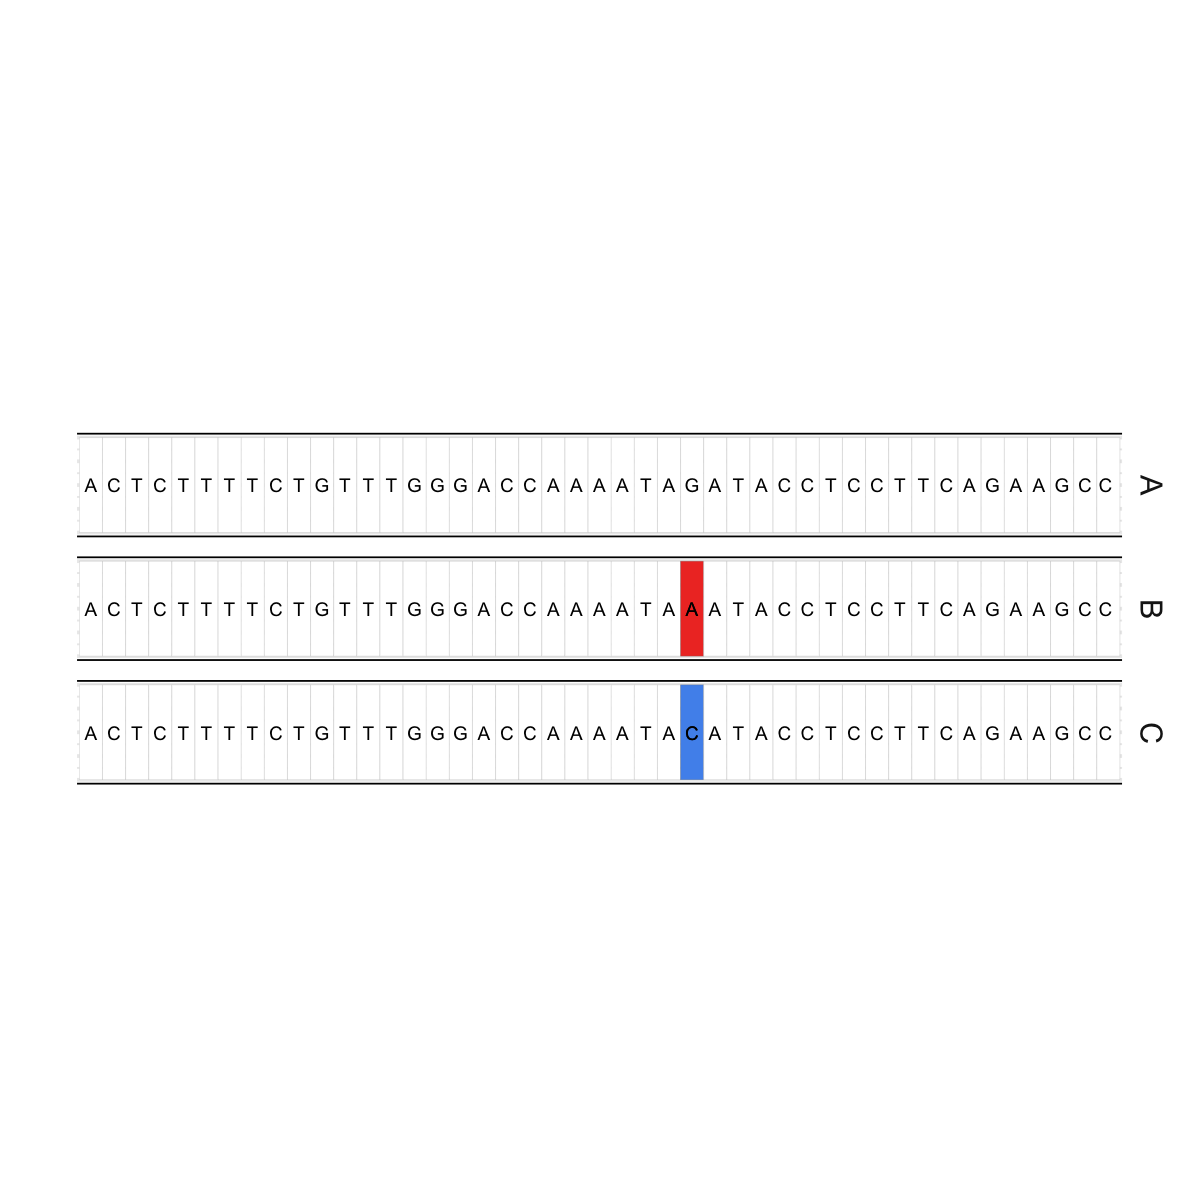

In [328]:
alleles_DNA_IL2RA_filt %>% Plotting_Alleles

In [329]:
IL2RA_gen <- Genotyping_Cells(alleles_DNA_IL2RA_filt)

In [330]:
IL2RA_gen <- IL2RA_gen %>% add_count(AllelicGenotype,name = "CellperGenotype") %>% filter(CellperGenotype>5)

In [331]:
IL2RA_gen$AllelicGenotype %>% table

.
  A  AB  AC   B 
722 750   7  59 

Joining with `by = join_by(RNA_Barcode)`
Rows: 384 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Well_ID, RNA_cell

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(RNA_cell)`
Joining with `by = join_by(plate_well)`
`summarise()` has grouped output by 'as.factor(IL2RA_Control)',
'as.factor(Individual_Index)'. You can override using the `.groups` argument.
Joining with `by = join_by(genotype, Individual_Index, Edited_Index)`


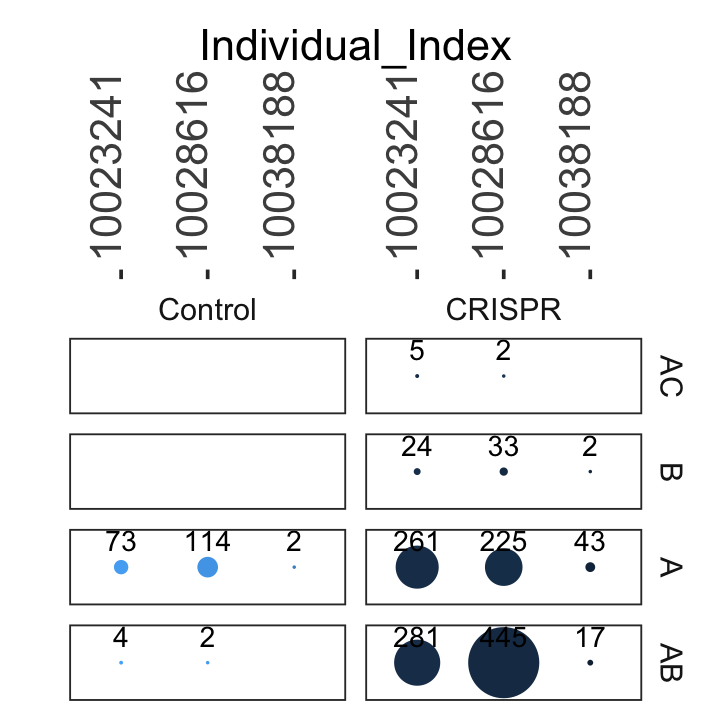

In [332]:
#Quick plot with flow cytometry data. 
test2 <- 
FlowMatrix %>% separate(cell, into = c("RNA_cell", "RNA_Barcode")) %>% inner_join(plateMeta0)%>% inner_join(read_csv("RNA_ADT_Barcodes.csv")) %>% 
mutate(plate_well = paste0(DNA_Barcode, Well_ID)) %>% inner_join(IL2RA_gen) %>% filter(Individual_Index != "Error")

#Defineplotting Order
order <- test2$AllelicGenotype %>% table %>% as_data_frame %>% arrange(`n`)
order <- as.character(order$`.`)


fig.size(6,6)
g <- 

table(test2$AllelicGenotype, test2$Individual_Index, test2$IL2RA_Control) %>% 
as.data.frame() %>% dplyr::rename(Individual_Index = Var2, Edited_Index = Var3, genotype = Var1) %>% 
inner_join( 
test2 %>% group_by(as.factor(IL2RA_Control), as.factor(Individual_Index), as.factor(AllelicGenotype)) %>% 
    summarise(mean(FITC_CD45)) %>% dplyr::rename(Individual_Index = `as.factor(Individual_Index)`, 
                                          Edited_Index = `as.factor(IL2RA_Control)`, genotype = `as.factor(AllelicGenotype)`)
)%>% na.omit%>% {
    
    ggplot(., aes(Individual_Index, 
                  fill = log10(`mean(FITC_CD45)`), size = Freq)) +
      geom_point(aes(y = 0),shape = 21, stroke = 0) +
      #geom_hline(yintercept = seq(.5, 4.5, 1), size = .2) +
  scale_x_discrete(position = "top") +
  scale_radius(range = c(1,20)) +
    geom_text(aes(y = 0, label = Freq), size =6, vjust = -0.8)+
  theme_gy() +
  theme(legend.position = "none", 
        panel.grid.major = element_blank(),
        legend.text = element_text(size = 8),
        legend.title = element_text(size = 8), 
       axis.text.x = element_text(angle = 90)) + 
    ylab("") + 
    scale_y_discrete(expand = c(0.1,0.5)) + 
    facet_grid(factor((genotype), levels = order)~Edited_Index) + 
    theme(
  strip.background = element_blank(),
  #strip.text.x = element_blank(), 
    #panel.border=element_blank(), 
   # strip.text.y = element_blank()  
        )
} 
plot(g)
suppressWarnings({ 
    ggsave(g, filename = "IL2RAGenotypes_Counts_FITC_legend.png", device = "png", dpi = 300, width = 6, height = 15)
    })

In [340]:
Run1meta <- FlowMatrix %>% separate(cell, into = c("RNA_cell", "RNA_Barcode")) %>% inner_join(plateMeta0)%>% inner_join(read_csv("RNA_ADT_Barcodes.csv")) %>% 
mutate(plate_well = paste0(DNA_Barcode, Well_ID)) %>% inner_join(IL2RA_gen) %>% filter(Individual_Index != "Error")%>% mutate(cell = paste0(RNA_cell, "_", RNA_Barcode)) %>%
inner_join(
    select(filt_meta, cell, nUMI, nGenes), by = "cell")%>% 
mutate(Dosage = ifelse(AllelicGenotype == "A", 0, ifelse(AllelicGenotype == "B", 2, ifelse(AllelicGenotype == "AB", 1, NA)))) %>% 
na.omit %>%  inner_join(
select(filt_meta_adt, nUMI, nGenes, cell) %>% dplyr::rename(nUMI_ADT = nUMI), by = "cell")

Joining with `by = join_by(RNA_Barcode)`
Rows: 384 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Well_ID, RNA_cell

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(RNA_cell)`
Joining with `by = join_by(plate_well)`


In [343]:
alleles_DNA_IL2RA_filt %>% select(plate_well, Barcode_DNA) %>% unique %>% select(Barcode_DNA) %>% table

Barcode_DNA
CATACACTGT CGTATAATCA TACGCGGCTG TGCCTGGTGG TGCGTGTCAC 
       314        310        319        282        313 

In [342]:
write_csv(Run1meta, "Run1meta_updated.csv")